In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [2]:
import os
import glob
import json

# --- CONFIGURATION ---
BASE_PATH = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/OCELOT/ocelot2023_v1.0.1"

def inspect_ocelot_structure(base_path):
    print(f"=== Inspecting OCELOT Dataset at: {base_path} ===\n")

    if not os.path.exists(base_path):
        print(f"Error: Path {base_path} does not exist.")
        return

    # 1. List Top-Level Directories
    top_level = os.listdir(base_path)
    print(f"Top-Level Contents: {top_level}\n")

    # 2. Iterate through subfolders to find images and annotations
    for item in top_level:
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path):
            print(f"--- Checking Subfolder: {item} ---")
            sub_contents = os.listdir(item_path)
            # Show first 5 items to keep output clean
            print(f"    Total items: {len(sub_contents)}")
            print(f"    Sample items: {sub_contents[:5]}")
            
            # Check for nested structures (e.g. train/val/test)
            for sub_item in sub_contents[:3]:
                 sub_item_path = os.path.join(item_path, sub_item)
                 if os.path.isdir(sub_item_path):
                     print(f"        -> Found nested folder: {sub_item}")
                     print(f"           Contents: {os.listdir(sub_item_path)[:5]}")
            print("")

    # 3. Look for JSON metadata files
    json_files = glob.glob(os.path.join(base_path, "**", "*.json"), recursive=True)
    print(f"--- JSON Metadata/Annotation Files Found: {len(json_files)} ---")
    for j in json_files:
        # Print relative path for readability
        print(f"    {os.path.relpath(j, base_path)}")

if __name__ == "__main__":
    inspect_ocelot_structure(BASE_PATH)

=== Inspecting OCELOT Dataset at: /rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/OCELOT/ocelot2023_v1.0.1 ===

Top-Level Contents: ['.DS_Store', 'annotations', 'images', 'metadata.json']

--- Checking Subfolder: annotations ---
    Total items: 4
    Sample items: ['.DS_Store', 'test', 'train', 'val']
        -> Found nested folder: test
           Contents: ['cell', 'tissue']
        -> Found nested folder: train
           Contents: ['.DS_Store', 'cell', 'tissue']

--- Checking Subfolder: images ---
    Total items: 4
    Sample items: ['.DS_Store', 'test', 'train', 'val']
        -> Found nested folder: test
           Contents: ['cell', 'tissue']
        -> Found nested folder: train
           Contents: ['.DS_Store', 'cell', 'tissue']

--- JSON Metadata/Annotation Files Found: 1 ---
    metadata.json


In [3]:
import os
import glob
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BASE_PATH = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/OCELOT/ocelot2023_v1.0.1"

def inspect_data_properties():
    print(f"=== Deep Inspection of OCELOT Data ===\n")
    
    # We will focus on the 'train' split for inspection
    splits = ['train'] # You can add 'val', 'test' if needed
    sub_types = ['cell', 'tissue']
    
    for split in splits:
        print(f"--- Inspecting Split: {split.upper()} ---")
        
        for sub_type in sub_types:
            print(f"\n[Sub-type: {sub_type.upper()}]")
            
            # 1. Inspect IMAGES
            img_dir = os.path.join(BASE_PATH, "images", split, sub_type)
            img_files = glob.glob(os.path.join(img_dir, "*"))
            
            # Filter for actual images (ignore .DS_Store)
            img_files = [f for f in img_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
            
            if not img_files:
                print(f"  No images found in {img_dir}")
                continue
                
            print(f"  Found {len(img_files)} images.")
            sample_img_path = img_files[0]
            print(f"  Sample Image File: {os.path.basename(sample_img_path)}")
            
            # Load Image
            img = cv2.imread(sample_img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                print(f"  -> Shape: {img.shape} (H, W, C)")
                print(f"  -> Dtype: {img.dtype}")
                print(f"  -> Range: {img.min()} - {img.max()}")
            else:
                print("  -> Error loading image with OpenCV")

            # 2. Inspect ANNOTATIONS
            # Note: The folder structure mirrors images: annotations/train/cell etc.
            ann_dir = os.path.join(BASE_PATH, "annotations", split, sub_type)
            ann_files = glob.glob(os.path.join(ann_dir, "*"))
             # Filter out .DS_Store
            ann_files = [f for f in ann_files if not f.endswith('.DS_Store')]
            
            if not ann_files:
                print(f"  No annotations found in {ann_dir}")
                continue
            
            print(f"  Found {len(ann_files)} annotation files.")
            sample_ann_path = ann_files[0]
            ext = os.path.splitext(sample_ann_path)[1].lower()
            print(f"  Sample Annotation File: {os.path.basename(sample_ann_path)} ({ext})")
            
            # Check Annotation Content based on extension
            if ext in ['.png', '.jpg', '.tif']:
                # It's a Mask
                mask = cv2.imread(sample_ann_path, cv2.IMREAD_UNCHANGED) # Load as is (often 1 channel)
                print(f"  -> Mask Shape: {mask.shape}")
                print(f"  -> Unique Values (Classes): {np.unique(mask)}")
                
            elif ext == '.json':
                # It's a JSON (likely points or polygons)
                try:
                    with open(sample_ann_path, 'r') as f:
                        data = json.load(f)
                    print(f"  -> JSON Keys: {list(data.keys())}")
                    # Try to peek at the first element if it's a list or dictionary
                    if isinstance(data, list) and len(data) > 0:
                        print(f"  -> Sample Entry: {data[0]}")
                    elif isinstance(data, dict):
                        # Print first key's content summary
                        first_k = list(data.keys())[0]
                        print(f"  -> Content of '{first_k}': {str(data[first_k])[:100]}...")
                except Exception as e:
                    print(f"  -> Error reading JSON: {e}")
                    
            elif ext == '.csv':
                 # It's a CSV (likely points)
                 try:
                     df = pd.read_csv(sample_ann_path)
                     print(f"  -> CSV Columns: {list(df.columns)}")
                     print(f"  -> First row:\n{df.iloc[0].to_dict()}")
                 except Exception as e:
                     print(f"  -> Error reading CSV: {e}")

    print("\n--- Metadata Check ---")
    meta_path = os.path.join(BASE_PATH, "metadata.json")
    if os.path.exists(meta_path):
        try:
            with open(meta_path, 'r') as f:
                meta = json.load(f)
            print(f"Metadata Keys: {list(meta.keys())}")
            if 'sample_pairs' in meta:
                 print(f"Sample pairs count: {len(meta['sample_pairs'])}")
        except:
            print("Could not read metadata.json")
    else:
        print("metadata.json not found.")

if __name__ == "__main__":
    inspect_data_properties()

=== Deep Inspection of OCELOT Data ===

--- Inspecting Split: TRAIN ---

[Sub-type: CELL]
  Found 400 images.
  Sample Image File: 001.jpg
  -> Shape: (1024, 1024, 3) (H, W, C)
  -> Dtype: uint8
  -> Range: 1 - 255
  Found 400 annotation files.
  Sample Annotation File: 001.csv (.csv)
  -> CSV Columns: ['42', '516', '2']
  -> First row:
{'42': 239, '516': 67, '2': 2}

[Sub-type: TISSUE]
  Found 400 images.
  Sample Image File: 001.jpg
  -> Shape: (1024, 1024, 3) (H, W, C)
  -> Dtype: uint8
  -> Range: 0 - 255
  Found 400 annotation files.
  Sample Annotation File: 001.png (.png)
  -> Mask Shape: (1024, 1024)
  -> Unique Values (Classes): [  1   2 255]

--- Metadata Check ---
Metadata Keys: ['general_info', 'label_info', 'field_description', 'sample_pairs']
Sample pairs count: 663


In [4]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import zarr
import shutil
from tqdm import tqdm

# --- CONFIGURATION ---
BASE_PATH = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/OCELOT/ocelot2023_v1.0.1"
OUTPUT_ZARR_ROOT = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ocelot/zarr_data"

# Tiling Config
TILE_SIZE = 512
STRIDE = 512  # No overlap

# Cell Rasterization Config
CELL_RADIUS = 5  # Radius for cell points -> mask

def create_directory_structure():
    """Ensures the zarr_data structure exists and cleans up previous runs."""
    if os.path.exists(OUTPUT_ZARR_ROOT):
        shutil.rmtree(OUTPUT_ZARR_ROOT) 
    os.makedirs(OUTPUT_ZARR_ROOT)

def pad_to_size(img, target_h, target_w):
    """
    Pads an image with zeros (bottom and right) to match target size.
    """
    h, w = img.shape[:2]
    if h == target_h and w == target_w:
        return img
    
    pad_h = target_h - h
    pad_w = target_w - w
    
    # Handle both 2D (Mask) and 3D (RGB) images
    if len(img.shape) == 3:
        # Pad: (top, bottom, left, right)
        padded = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    else:
        padded = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
        
    return padded

def get_tiles_padded(image, tile_size=512, stride=512):
    """
    Generator that yields 512x512 tiles.
    If the crop is smaller than 512, it zero-pads it.
    """
    h, w = image.shape[:2]
    
    # Generate coordinates
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            # Calculate crop coordinates
            y_end = min(y + tile_size, h)
            x_end = min(x + tile_size, w)
            
            # Crop
            tile = image[y:y_end, x:x_end]
            
            # Pad if necessary (e.g., if tile is 300x512)
            if tile.shape[0] != tile_size or tile.shape[1] != tile_size:
                tile = pad_to_size(tile, tile_size, tile_size)
            
            yield tile

def process_cell_annotation(csv_path, shape):
    """
    Reads CSV points and rasterizes them into a Mask image.
    """
    h, w = shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    
    try:
        # Load CSV (No header assumed based on inspection)
        df = pd.read_csv(csv_path, header=None)
        
        for idx, row in df.iterrows():
            # CSV format: X, Y, Class
            x = int(row[0])
            y = int(row[1])
            class_id = int(row[2]) # Typically 2 for cells in OCELOT
            
            # Draw circle
            cv2.circle(mask, (x, y), CELL_RADIUS, class_id, -1)
            
    except Exception as e:
        # Some images might not have cells, leading to empty CSVs or errors
        pass 
        
    return mask

def process_tissue_annotation(png_path):
    """Reads PNG mask."""
    mask = cv2.imread(png_path, cv2.IMREAD_UNCHANGED)
    return mask

def save_to_zarr(split, subtype, img_id, img_tiles, mask_tiles):
    """
    Saves: img and nuclei arrays.
    """
    store_path = os.path.join(OUTPUT_ZARR_ROOT, split, subtype, f"{img_id}.zarr")
    store = zarr.DirectoryStore(store_path)
    root = zarr.group(store=store, overwrite=True)
    
    img_stack = np.stack(img_tiles, axis=0)
    mask_stack = np.stack(mask_tiles, axis=0)
    
    # Save datasets (Chunking by 1 tile usually optimal for Dataloaders)
    # Using 'nuclei' key as requested
    root.create_dataset('img', data=img_stack, chunks=(1, *img_stack.shape[1:]), compressor=zarr.Blosc(cname='zstd', clevel=3))
    root.create_dataset('nuclei', data=mask_stack, chunks=(1, *mask_stack.shape[1:]), compressor=zarr.Blosc(cname='zstd', clevel=3))

def main():
    create_directory_structure()
    
    splits = ['train', 'val', 'test'] 
    subtypes = ['cell', 'tissue']
    
    for split in splits:
        for subtype in subtypes:
            print(f"--- Processing {split}/{subtype} ---")
            
            img_dir = os.path.join(BASE_PATH, "images", split, subtype)
            ann_dir = os.path.join(BASE_PATH, "annotations", split, subtype)
            
            # Get valid images
            img_files = glob.glob(os.path.join(img_dir, "*"))
            img_files = [f for f in img_files if f.lower().endswith(('.jpg', '.png'))]
            
            # Create output folder
            os.makedirs(os.path.join(OUTPUT_ZARR_ROOT, split, subtype), exist_ok=True)
            
            for img_path in tqdm(img_files):
                filename = os.path.basename(img_path)
                img_id = os.path.splitext(filename)[0]
                
                # 1. Load Image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # 2. Generate Mask
                mask = None
                if subtype == 'cell':
                    csv_path = os.path.join(ann_dir, img_id + ".csv")
                    if os.path.exists(csv_path):
                        mask = process_cell_annotation(csv_path, img.shape)
                    else:
                        mask = np.zeros(img.shape[:2], dtype=np.uint8)
                        
                elif subtype == 'tissue':
                    # Try png, then jpg
                    mask_path = os.path.join(ann_dir, img_id + ".png")
                    if not os.path.exists(mask_path):
                        mask_path = os.path.join(ann_dir, img_id + ".jpg")
                        
                    if os.path.exists(mask_path):
                        mask = process_tissue_annotation(mask_path)
                    else:
                        mask = np.zeros(img.shape[:2], dtype=np.uint8)

                # 3. Tile with Zero Padding
                img_tiles = list(get_tiles_padded(img, TILE_SIZE, STRIDE))
                mask_tiles = list(get_tiles_padded(mask, TILE_SIZE, STRIDE))
                
                # 4. Save
                if img_tiles:
                    save_to_zarr(split, subtype, img_id, img_tiles, mask_tiles)

if __name__ == "__main__":
    main()

--- Processing train/cell ---


100%|██████████| 400/400 [01:44<00:00,  3.81it/s]


--- Processing train/tissue ---


100%|██████████| 400/400 [02:21<00:00,  2.84it/s]


--- Processing val/cell ---


100%|██████████| 137/137 [00:35<00:00,  3.91it/s]


--- Processing val/tissue ---


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


--- Processing test/cell ---


100%|██████████| 126/126 [00:34<00:00,  3.66it/s]


--- Processing test/tissue ---


100%|██████████| 126/126 [00:34<00:00,  3.61it/s]


Total Zarr files found: 1326

=== Inspecting: train/tissue/295.zarr ===
  Keys found: ['img', 'nuclei']
  Image Stack Shape: (4, 512, 512, 3)
  Mask Stack Shape:  (4, 512, 512)
  Mask Unique Vals:  [  1   2 255]


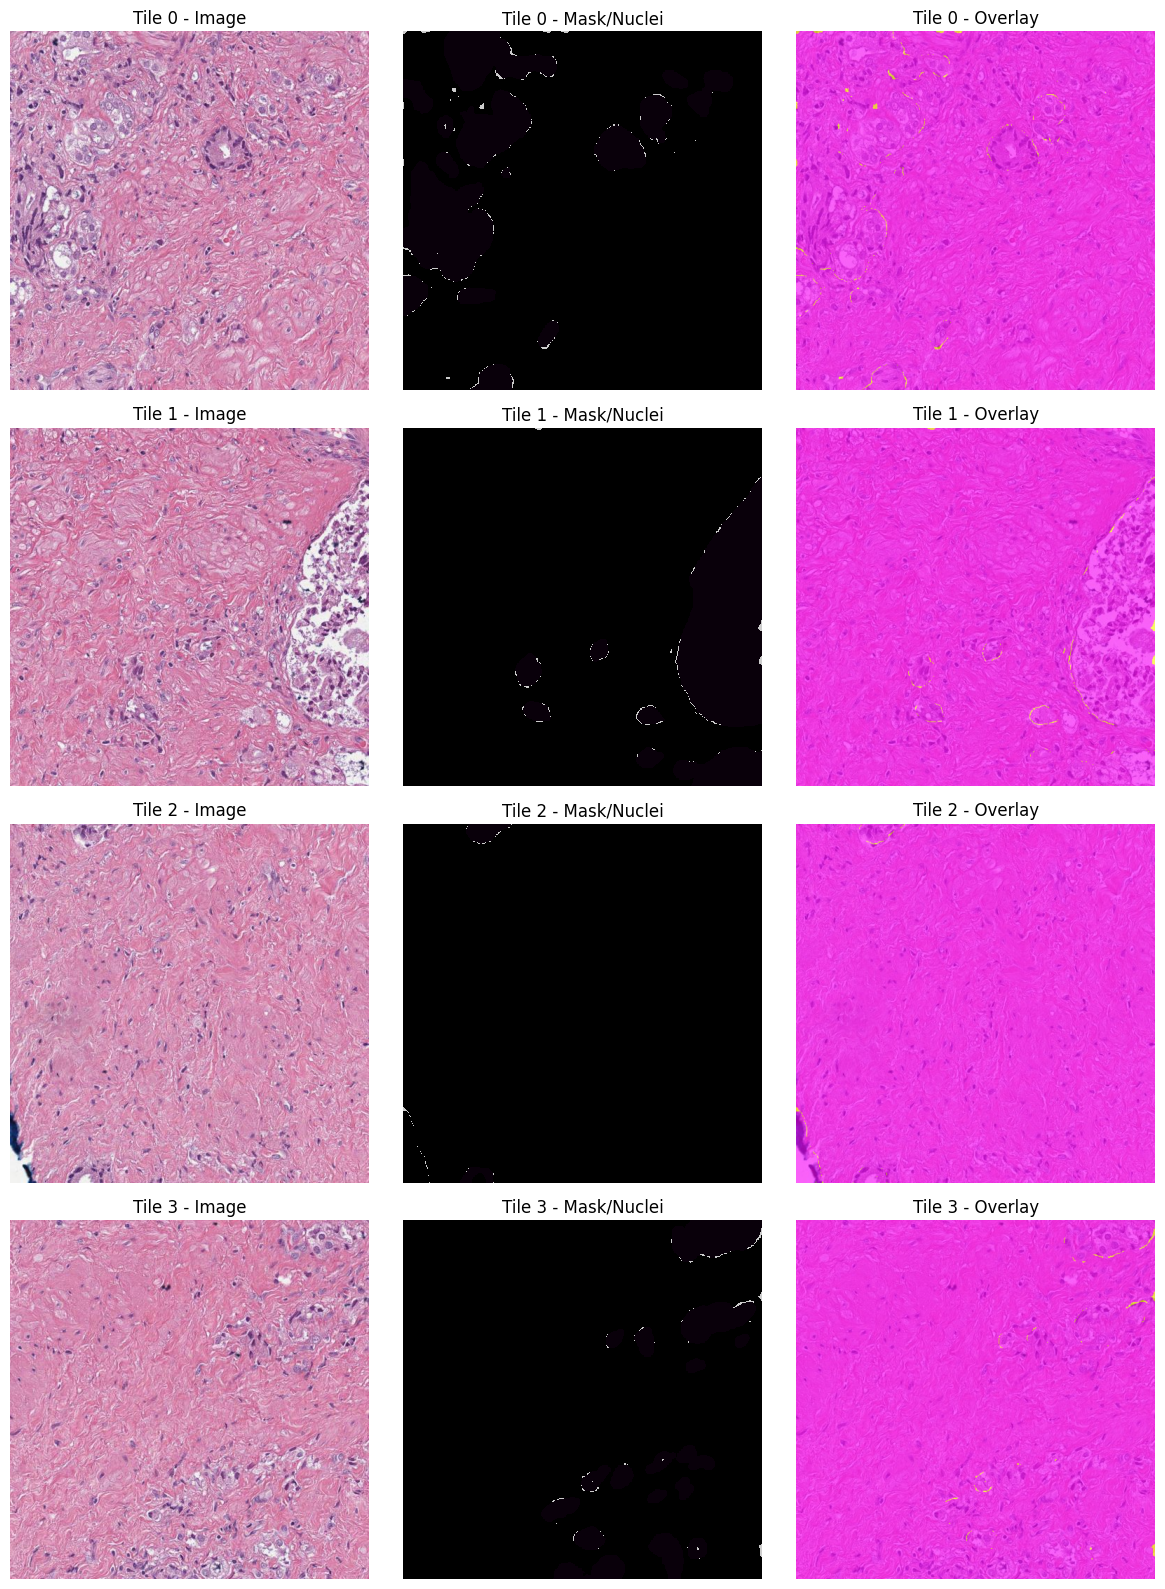


=== Inspecting: train/tissue/178.zarr ===
  Keys found: ['img', 'nuclei']
  Image Stack Shape: (4, 512, 512, 3)
  Mask Stack Shape:  (4, 512, 512)
  Mask Unique Vals:  [  1   2 255]


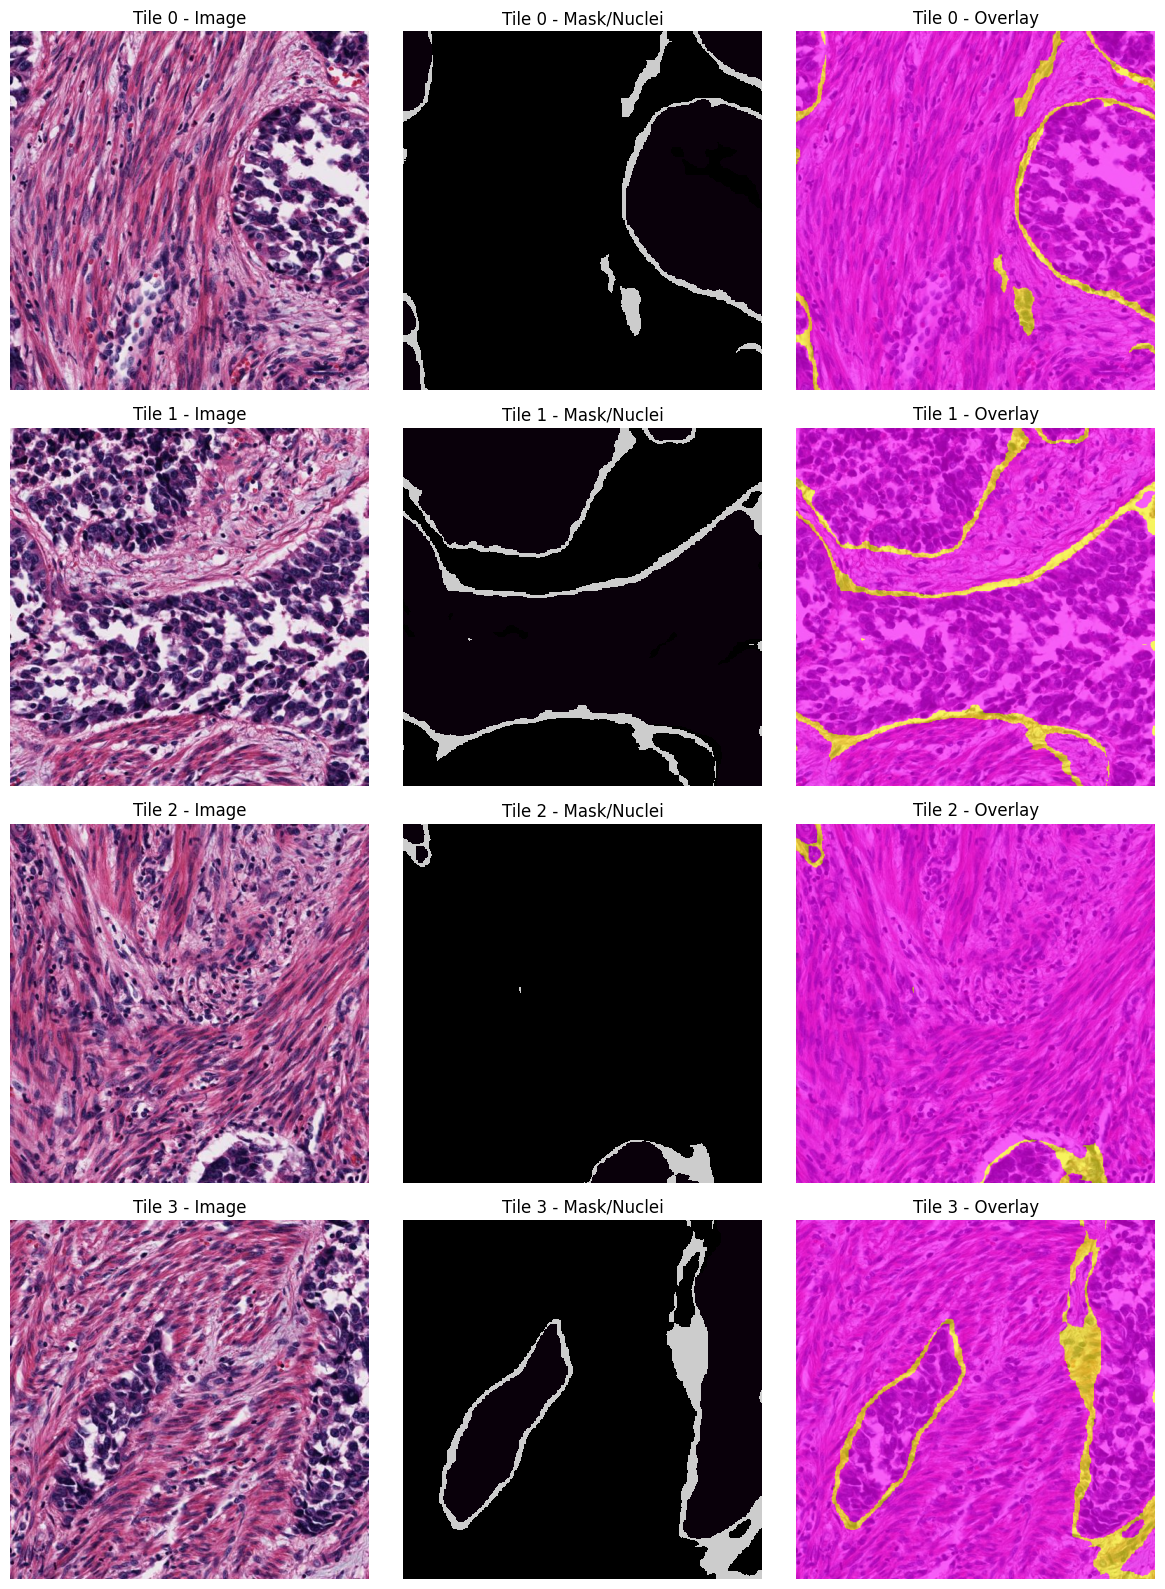


=== Inspecting: train/cell/254.zarr ===
  Keys found: ['img', 'nuclei']
  Image Stack Shape: (4, 512, 512, 3)
  Mask Stack Shape:  (4, 512, 512)
  Mask Unique Vals:  [0 1]


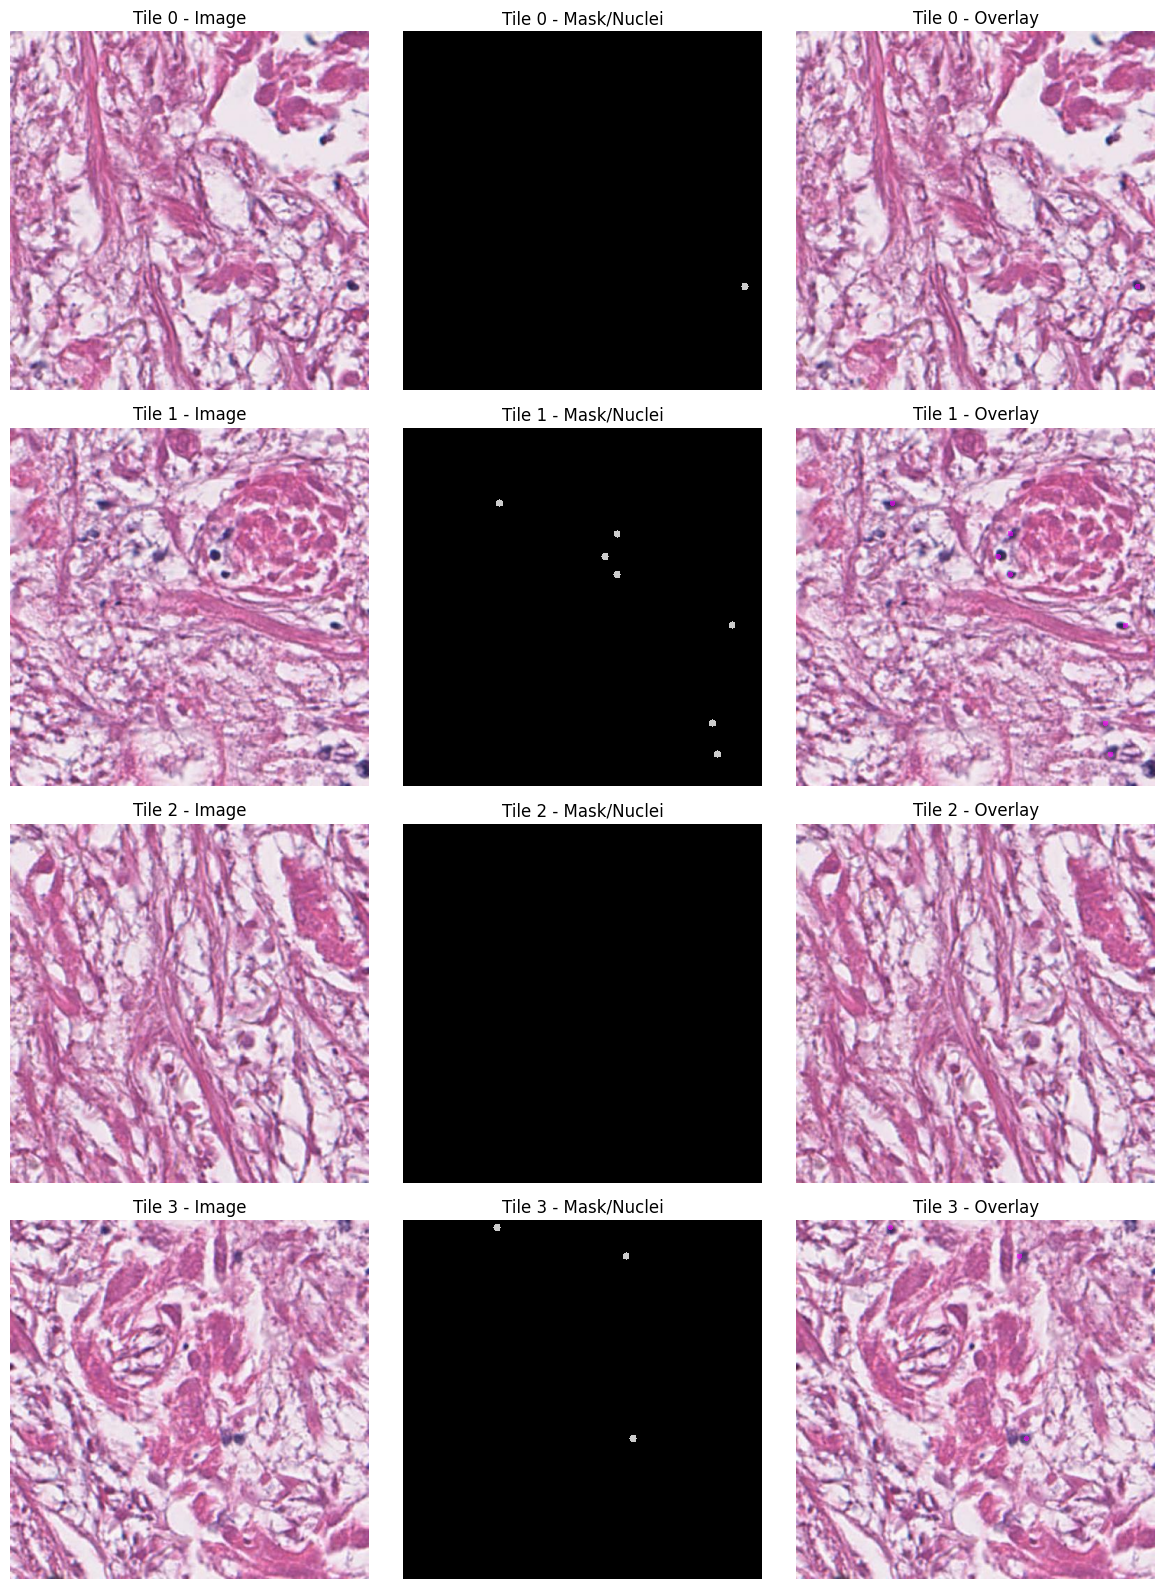

In [6]:
import os
import glob
import numpy as np
import zarr
import matplotlib.pyplot as plt
import random

# --- CONFIGURATION ---
ZARR_ROOT = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/OCELOT/zarr_data"

def visualize_zarr_sample(zarr_path):
    print(f"\n=== Inspecting: {os.path.relpath(zarr_path, ZARR_ROOT)} ===")
    
    # 1. Load Zarr Group (Corrected Method)
    # zarr.open handles the mode correctly
    root = zarr.open(zarr_path, mode='r') 
    
    # 2. Keys check
    # Note: .keys() works for groups, .array_keys() is specific to some versions
    keys = list(root.keys())
    print(f"  Keys found: {keys}")
    
    if 'img' not in keys or 'nuclei' not in keys:
        print("  Error: Missing 'img' or 'nuclei' arrays.")
        return

    # 3. Load Data
    img_stack = root['img'][:]
    mask_stack = root['nuclei'][:]
    
    print(f"  Image Stack Shape: {img_stack.shape}") # (N, 512, 512, 3)
    print(f"  Mask Stack Shape:  {mask_stack.shape}") # (N, 512, 512)
    
    # Check distinct values in mask
    unique_vals = np.unique(mask_stack)
    print(f"  Mask Unique Vals:  {unique_vals}")
    if len(unique_vals) > 20:
        print("  (Many unique values detected - likely instance IDs)")
    
    # 4. Visualize Tiles
    n_tiles = img_stack.shape[0]
    
    # Setup grid: rows = tiles, cols = 3 (Image, Mask, Overlay)
    # Adjust figure size based on number of tiles
    fig, axes = plt.subplots(n_tiles, 3, figsize=(12, 4 * n_tiles))
    
    # Ensure axes is always 2D array [row, col] even if n_tiles=1
    if n_tiles == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i in range(n_tiles):
        img = img_stack[i]
        mask = mask_stack[i]
        
        # Original Image
        ax_img = axes[i][0]
        ax_img.imshow(img)
        ax_img.set_title(f"Tile {i} - Image")
        ax_img.axis('off')
        
        # Mask
        ax_mask = axes[i][1]
        # Use a distinct colormap
        ax_mask.imshow(mask, cmap='nipy_spectral', interpolation='nearest')
        ax_mask.set_title(f"Tile {i} - Mask/Nuclei")
        ax_mask.axis('off')
        
        # Overlay
        ax_overlay = axes[i][2]
        ax_overlay.imshow(img)
        # Create a masked array so 0 (background) is transparent
        mask_viz = np.ma.masked_where(mask == 0, mask)
        ax_overlay.imshow(mask_viz, cmap='spring', alpha=0.6)
        ax_overlay.set_title(f"Tile {i} - Overlay")
        ax_overlay.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Gather all zarr files
    all_zarrs = glob.glob(os.path.join(ZARR_ROOT, "*", "*", "*.zarr"))
    
    if not all_zarrs:
        print("No Zarr files found! Check paths.")
        return

    print(f"Total Zarr files found: {len(all_zarrs)}")
    
    # Strategy: Pick 1 random 'cell' sample and 1 random 'tissue' sample
    cell_zarrs = [f for f in all_zarrs if 'cell' in f]
    tissue_zarrs = [f for f in all_zarrs if 'tissue' in f]
    
    samples = []
    if cell_zarrs: samples.append(random.choice(cell_zarrs))
    if tissue_zarrs: samples.append(random.choice(tissue_zarrs))
    
    # Add one more random one for coverage
    if len(all_zarrs) > 0:
        samples.append(random.choice(all_zarrs))
    
    # Deduplicate
    samples = list(set(samples))

    for sample in samples:
        visualize_zarr_sample(sample)

if __name__ == "__main__":
    main()